This notebook is freely available for redistribution under the [GPL-3.0 license](https://choosealicense.com/licenses/gpl-3.0/).

Author: 蘇嘉冠 feabries@gmail.com

Contributors: 蘇郁翔 asdfghjkl225836@gmail.com

# 人工智慧與工程應用實作 2023 作業五

請先登入 Google 帳號並且複製一份至你的 Google Drive，將複製的那份改名為 `hw5_學號.ipynb`，並且用複製的那份寫作業

## 物件偵測篩選器

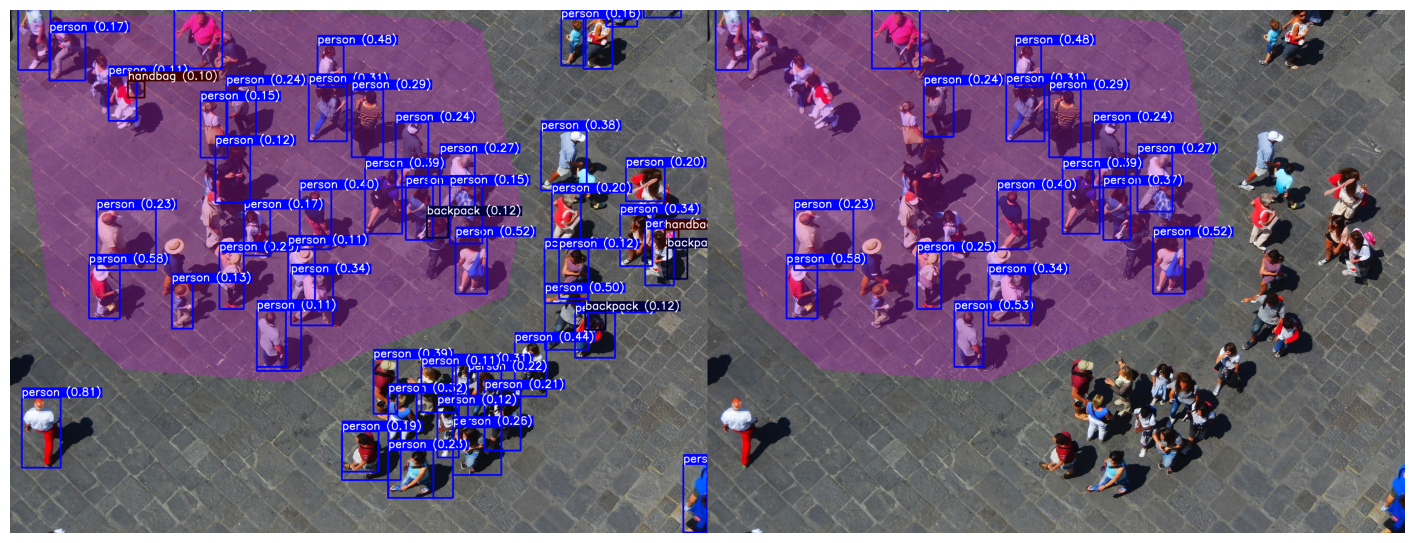

在實際的 AI 應用中，模型只會是其中一個步驟，我們常常還需要對模型的結果再進一步處理，來滿足應用的需求

這次作業我們蒐集了 100 張圖片，並且用 yolov8 內建的模型做物件偵測，我們要請你協助對偵測的結果做條件篩選

這次作業的圖片資料來源：
- [pixabay](https://pixabay.com/)
- [Pexels](https://www.pexels.com/)
- [PRW (Person Re-identification in the Wild) Dataset](http://zheng-lab.cecs.anu.edu.au/Project/project_prw.html)
- [GCC Dataset](https://gjy3035.github.io/GCC-CL/)
- [Robust Multi-Person Tracking from Mobile Platforms](https://data.vision.ee.ethz.ch/cvl/aess/dataset/)
- [SmartCity Dataset](https://github.com/miao0913/SaCNN-CrowdCounting-Tencent_Youtu)

In [ ]:
!pip install numpy matplotlib opencv-python Pillow

### 資料準備

先來下載這次的資料。執行以下區塊後會在 colab 得到資料夾 `images` 以及檔案 `samples_before.json`（你可以按一下 colab 界面左邊的 `檔案`）

In [ ]:
!rm -rf images samples_before.json && wget https://raw.githubusercontent.com/AINTUT/code_2023/main/datasets/hw5_samples.zip -O hw5_samples.zip && unzip hw5_samples.zip && rm hw5_samples.zip

來看一下 `images` 下的檔案列表，是一張一張的圖片

In [ ]:
!ls images

`samples_before.json` 是一個 [JSON](https://developer.mozilla.org/en-US/docs/Learn/JavaScript/Objects/JSON) 格式的檔案，我們可以直接讀取它並且將內容儲存在一個 Python 變數：`samples_before`

In [ ]:
import json

with open("samples_before.json", "r") as file_obj:
    samples_before = json.load(file_obj)

`samples_before` 為長度為 100 的 list of dict，一個 dict 代表一個 sample，一個 sample 包含一張圖片、對該圖片做物件偵測的結果、篩選條件等資訊

In [ ]:
print("Number of samples: {}".format(len(samples_before)))

In [ ]:
print(samples_before[0])

### 說明與範例

我們的目標是對 `samples_before` 的每個 sample（`sample_before`）根據條件篩選來修改內容（`sample_after`）

#### 視覺化函式

以下程式碼區塊提供了一個視覺化的 function：`visualize()`，可以幫助你比較篩選前跟篩選後的差別，確認篩選後的結果是否正確。

程式碼有點長你可以先不仔細看，之後有需要的話你可以自己再修改這段程式碼

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

colormap = {
    "person": (255, 0, 0), "bicycle": (0, 255, 0), "car": (0, 0, 255), "motorcycle": (255, 255, 0),
    "airplane": (255, 0, 255), "bus": (0, 255, 255), "train": (128, 0, 0), "truck": (0, 128, 0),
    "boat": (0, 0, 128), "traffic light": (128, 255, 0), "fire hydrant": (128, 0, 255),
    "stop sign": (0, 128, 255), "parking meter": (255, 128, 0), "bench": (255, 0, 128),
    "bird": (0, 255, 128), "cat": (128, 128, 0), "dog": (128, 0, 128), "horse": (0, 128, 128),
    "sheep": (192, 0, 0), "cow": (0, 192, 0), "elephant": (0, 0, 192), "bear": (192, 192, 0),
    "zebra": (192, 0, 192), "giraffe": (0, 192, 192), "backpack": (64, 0, 0), "umbrella": (0, 64, 0),
    "handbag": (0, 0, 64), "tie": (64, 255, 0), "suitcase": (64, 0, 255), "frisbee": (0, 64, 255),
    "skis": (255, 64, 0), "snowboard": (255, 0, 64), "sports ball": (0, 255, 64), "kite": (64, 64, 0),
    "baseball bat": (64, 0, 64), "baseball glove": (0, 64, 64), "skateboard": (128, 64, 0),
    "surfboard": (128, 0, 64), "tennis racket": (0, 128, 64), "bottle": (64, 128, 0),
    "wine glass": (64, 0, 128), "cup": (0, 64, 128), "fork": (128, 128, 64), "knife": (128, 64, 128),
    "spoon": (64, 128, 128), "bowl": (192, 64, 0), "banana": (192, 0, 64), "apple": (0, 192, 64),
    "sandwich": (64, 192, 0), "orange": (64, 0, 192), "broccoli": (0, 64, 192), "carrot": (128, 192, 0),
    "hot dog": (128, 0, 192), "pizza": (0, 128, 192), "donut": (64, 192, 128), "cake": (192, 64, 128),
    "chair": (192, 128, 64), "couch": (64, 128, 192), "potted plant": (32, 32, 32), "bed": (96, 96, 96),
    "dining table": (160, 160, 160), "toilet": (224, 224, 224), "tv": (32, 160, 32), "laptop": (160, 32, 32),
    "mouse": (32, 32, 160), "remote": (160, 160, 32), "keyboard": (160, 32, 160), "cell phone": (32, 160, 160),
    "microwave": (96, 96, 32), "oven": (96, 32, 96), "toaster": (32, 96, 96), "sink": (96, 160, 96),
    "refrigerator": (160, 96, 96), "book": (96, 96, 160), "clock": (160, 160, 96), "vase": (160, 96, 160),
    "scissors": (96, 160, 160), "teddy bear": (32, 96, 32), "hair drier": (96, 32, 32), "toothbrush": (32, 32, 96),
}

def count_num_filtered(sample):
    return len([
        detection
        for detection in sample["detections"]
        if detection["filtered"]
    ])

def draw_sample(sample, show_roi=True, show_label=True):
    img = cv2.imread(sample["image"])
    roi = sample["condition"]["roi"]

    if (show_roi) and (sample["condition"]["roi"] is not None):
        region = roi["region"]

        if roi["type"] == "rectangle":
            polygon = np.array([
                [region["xmin"], region["ymin"]],
                [region["xmax"], region["ymin"]],
                [region["xmax"], region["ymax"]],
                [region["xmin"], region["ymax"]],
            ])
        else:
            polygon = np.array(region)

        overlay = img.copy()
        overlay = cv2.fillPoly(overlay, [polygon], (200, 30, 200))
        img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

    for detection in sample["detections"]:
        if detection["filtered"]:
            continue

        bbox = detection["bbox"]
        xmin = bbox["xmin"]
        ymin = bbox["ymin"]
        xmax = bbox["xmax"]
        ymax = bbox["ymax"]
        label = detection["label"]
        confidence = detection["confidence"]

        color = colormap[label]

        img = cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            thickness=3,
        )

        if show_label:
            label_text = "{} ({:.2f})".format(label, confidence)
            label_size, _ = cv2.getTextSize(
                label_text,
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                2,
            )
            label_w, label_h = label_size
            img = cv2.rectangle(
                img,
                (xmin, ymin - label_h - 5),
                (xmin + label_w, ymin),
                color,
                -1,
            )
            img = cv2.putText(
                img,
                label_text,
                (xmin, ymin - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                2,
            )

    return img

def visualize(sample_before, sample_after, show_roi=True, show_label=True):
    print("Image path: {}".format(sample_before["image"]))

    print("Condition for target labels: {}".format(
        sample_before["condition"]["target_labels"],
    ))
    print("Condition for confidence threshold: {}".format(
        sample_before["condition"]["confidence_threshold"],
    ))

    print("Number of filtered detection(s) (before): {}".format(
        count_num_filtered(sample_before)),
    )
    print("Number of filtered detection(s) (after): {}".format(
        count_num_filtered(sample_after)),
    )

    img_before = draw_sample(
        sample_before,
        show_label=show_label,
        show_roi=show_roi,
    )
    img_after = draw_sample(
        sample_after,
        show_label=show_label,
        show_roi=show_roi,
    )

    img = np.hstack([img_before, img_after])

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### 資料詳細說明

一個 sample 有 3 個欄位：`image`, `detections`, `condition`

In [ ]:
print(list(samples_before[0].keys()))

`image` 的為字串，代表圖片的路徑

In [ ]:
print(samples_before[0]["image"])

`detections` 為 list of dict，代表對該圖片做物件偵測的結果，每個 dict（稱為一個 detection）有以下欄位：
- `bbox`:該 detection 的 bounding box，是一個 dict，包含 `xmin`, `ymin`, `xmax`, `ymax` 四個整數
- `confidence`：該 detection 的信心值，是一個浮點數
- `label`：該 detection 的 label，是一個字串，會是 [MSCOCO Dataset](https://cocodataset.org/#explore) 80 個 label 的其中一個
- `filtered`：該 detection 是否會被篩選掉，是的話要填 `True`，不是的話要填 `False`。**目前這裡都會是 `False`，你需要根據篩選條件（`condition` 的內容）將某些 detection 的 `filtered` 值改為 `True`**

In [ ]:
print(len(samples_before[0]["detections"]))
print(samples_before[0]["detections"][0])

`condition` 為 dict，有 `target_labels`, `confidence_threshold`, `roi` 三個欄位。每個欄位的值為 `None` 時，代表不需要理會該篩選條件，`None` 以外的值的話則需要

例如下面程式碼只有 `roi` 為 `None`，代表需要對 `target_labels`, `confidence_threshold` 的條件做篩選

In [ ]:
print(samples_before[0]["condition"])

#### Condition 1

`target_labels` 為 list of str，代表目標的 label(s)。如果某個 detection 的 label 不在目標內，會被篩選掉

以下示範 `target_labels` 為 `["cow"]`，所有 label 不是 `"cow"` 的 detection 都被篩選掉

In [ ]:
sample_before = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": ["cow"],
    "confidence_threshold": None,
    "roi": None,
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

sample_after = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": ["cow"],
    "confidence_threshold": None,
    "roi": None,
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": True,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

visualize(sample_before, sample_after)

#### Condition 2

`confidence_threshold` 為浮點數，代表能接受的最低信心值。如果某個 detection 的 confidence 小於（不包含等於）該數值時，會被篩選掉

以下示範 `confidence_threshold` 為 `0.96`，所有 confidence 小於 0.96 的 detection 都被篩選掉

In [ ]:
sample_before = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": 0.96,
    "roi": None,
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

sample_after = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": 0.96,
    "roi": None,
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": True,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": True,
    }
  ]
}

visualize(sample_before, sample_after)

#### Condition 3-1

`roi` 為 dict，roi 是 region of interest，代表感興趣的區域。如果某個 detection 進入 roi 的比率大於等於 **0.5** 時，會留下該 detection，否則會被篩選掉

`roi` 有兩個欄位：`type` 與 `region`。當 `type` 的值為 `rectangle` 時，表示該 roi 是一個矩形，`region` 會是一個 dict，有 `xmin`, `ymin`, `xmax`, `ymax`（定義同 bounding box）

某 detection 進入 roi 的比率的計算方法為：

$\frac{roi\ 與\ detection\ 交集所形成的\ bbox\ 面積}{detection\ 本身\ bbox\ 的面積}$

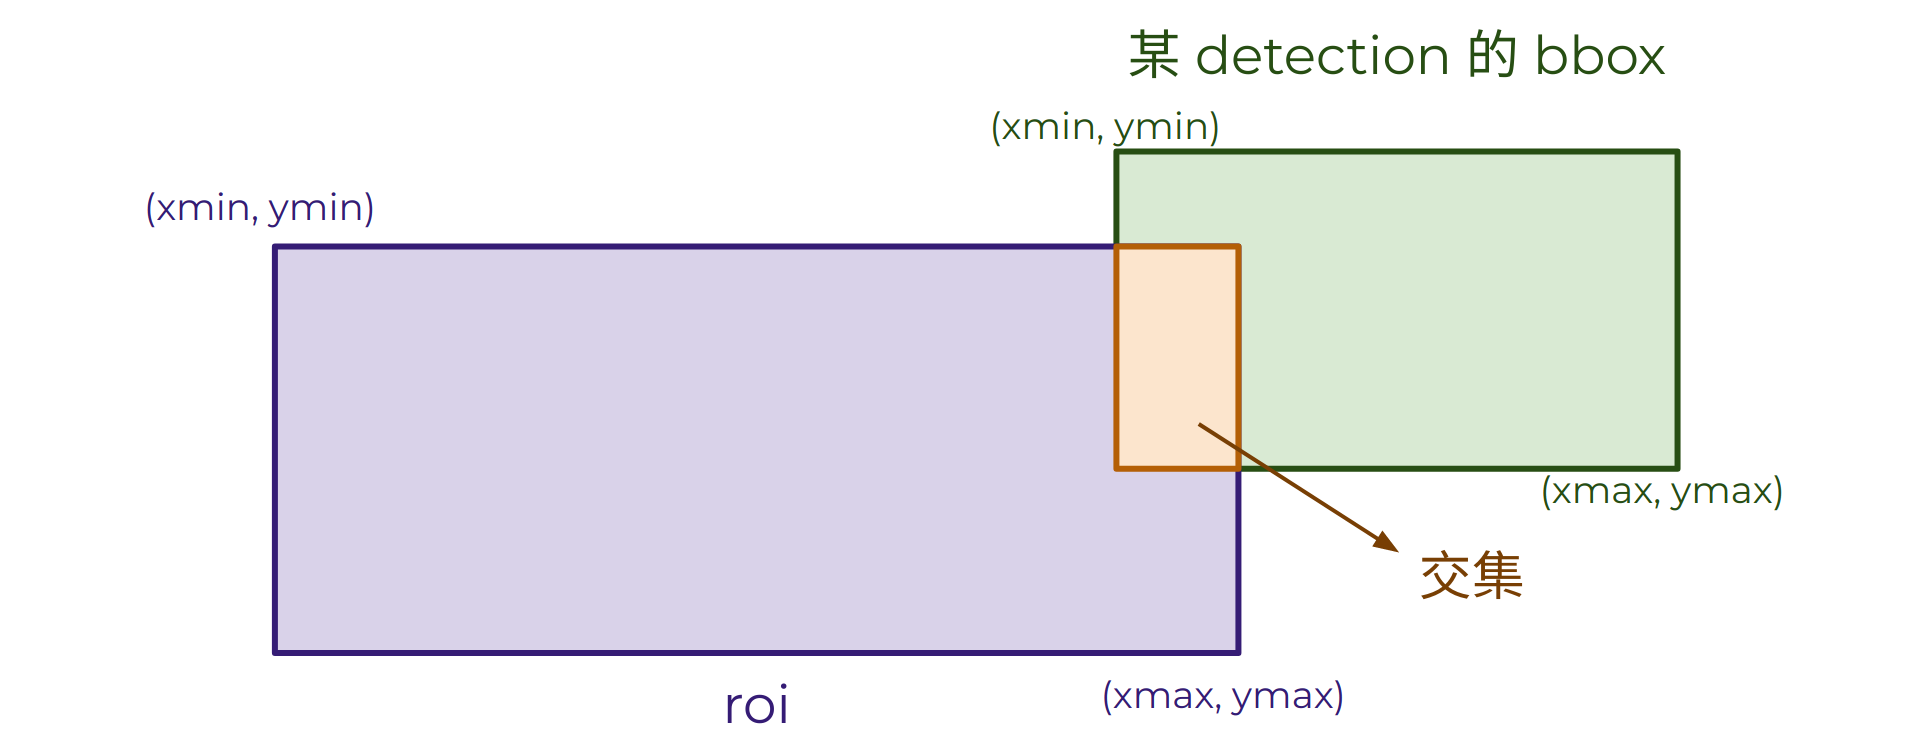

一個 bounding box 的面積等同於它所佔的像素量，例如當 bbox 為：
- `xmin`: 100
- `ymin`: 70
- `xmax`: 199
- `ymax`: 149

則面積為：(199 - 100 + 1) * (149 - 70 + 1) = 8000

以下示範的 3 個 detection 進入 roi 的比率分別為：
- 0.8430047590250572
- 0.0
- 0.2767857142857143

只有第 0 個 detection 的比率大於等於 0.5 被留下，其他兩個都被篩選掉

In [ ]:
sample_before = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": None,
    "roi": {
        "type": "rectangle",
        "region": {
            "xmin": 10,
            "ymin": 300,
            "xmax": 400,
            "ymax": 850,
        }
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

sample_after = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": None,
    "roi": {
        "type": "rectangle",
        "region": {
            "xmin": 10,
            "ymin": 300,
            "xmax": 400,
            "ymax": 850,
        }
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": True,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": True,
    }
  ]
}

visualize(sample_before, sample_after)

#### Condition 3-2

`roi` 的另一種可能，當 `type` 的值為 `polygon` 時，表示該 roi 是一個多邊形，`region` 會是一個 list of list，每個內層 list 為多邊形的一個點 (x, y)，外層 list 表示好幾個點構成一個多邊形


邏輯同 rectangle，某 detection 進入 roi 的比率的計算方法為：

$\frac{roi\ 與\ detection\ 交集所形成的\ polygon\ 面積}{detection\ 本身\ bbox\ 的面積}$

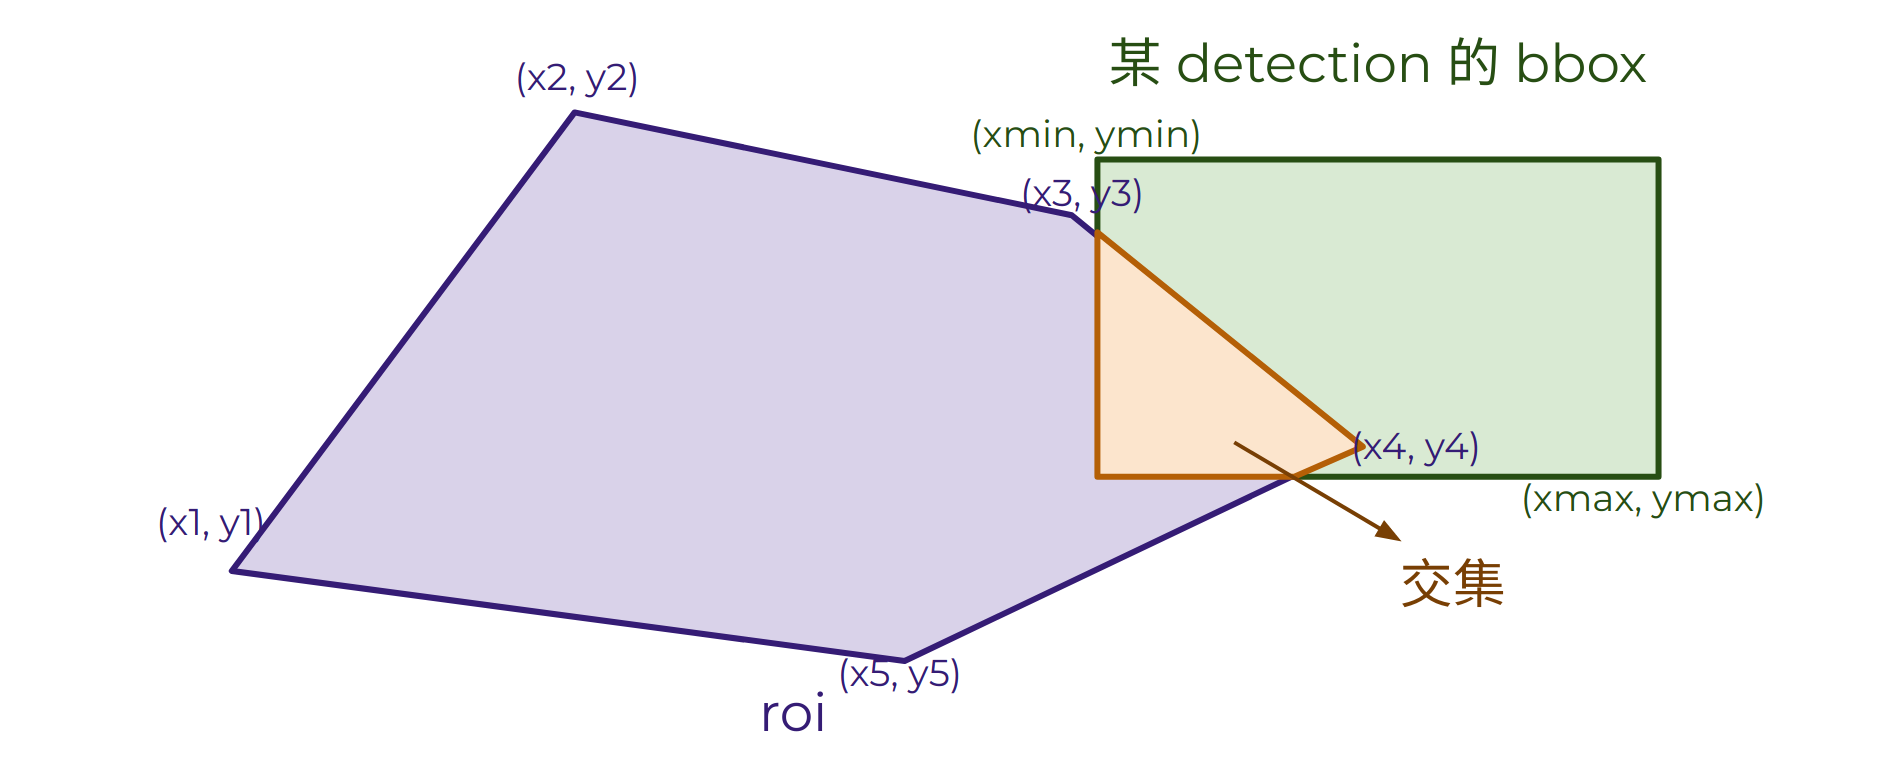

一個 polygon 的面積等同於它所佔的像素量，例如以下 polygon 的面積為 414592 ：

`[[301, 234], [718, 229], [1065, 470], [1036, 894], [716, 903], [484, 796], [279, 523]]`

以下示範的 3 個 detection 進入 roi 的比率分別為：
- 0.1838491134891629
- 0.9563667265765414
- 0.8608881913810655

只有第 0 個 detection 的比率小於 0.5 被篩選掉，其他兩個都被留下

In [ ]:
sample_before = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": None,
    "roi": {
        "type": "polygon",
        "region": [[301, 234], [718, 229], [1065, 470], [1036, 894], [716, 903], [484, 796], [279, 523]],
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

sample_after = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": None,
    "confidence_threshold": None,
    "roi": {
        "type": "polygon",
        "region": [[301, 234], [718, 229], [1065, 470], [1036, 894], [716, 903], [484, 796], [279, 523]],
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": True,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

visualize(sample_before, sample_after)

#### 多個 Conditions

以下是同時考慮 `target_labels` 與 `roi` 兩個篩選條件的範例

In [ ]:
sample_before = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": ["cow"],
    "confidence_threshold": None,
    "roi": {
        "type": "polygon",
        "region": [[301, 234], [718, 229], [1065, 470], [1036, 894], [716, 903], [484, 796], [279, 523]],
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": False,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": False,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

sample_after = {
  "image": "images/none_00.jpg",
  "condition": {
    "target_labels": ["cow"],
    "confidence_threshold": None,
    "roi": {
        "type": "polygon",
        "region": [[301, 234], [718, 229], [1065, 470], [1036, 894], [716, 903], [484, 796], [279, 523]],
    },
  },
  "detections": [{
      "bbox": {"xmin": 0, "ymin": 359, "xmax": 437, "ymax": 879},
      "confidence": 0.9667603969573975,
      "label": "cow",
      "filtered": True,
    }, {
      "bbox": {"xmin": 749, "ymin": 534, "xmax": 1016, "ymax": 915},
      "confidence": 0.9515905976295471,
      "label": "dog",
      "filtered": True,
    }, {
      "bbox": {"xmin": 246, "ymin": 317, "xmax": 805, "ymax": 737},
      "confidence": 0.9483015537261963,
      "label": "cow",
      "filtered": False,
    }
  ]
}

visualize(sample_before, sample_after)

#### 分數計算方式

對於每個 sample，我們會用你修改後的內容（`sample_after`）與真實答案（`sample_after_gt`）比較，當該 sample 每個 detection 的 `filtered` 欄位的值與真實答案一樣時，該 sample 算答對，得到 1 分。總共有 100 個 sample，最高 100 分

#### 資料組成

`samples_before` 的 100 個 sample 由以下組成，建議你按照順序解決：
- 0 ~ 59：圖片 `none_00.jpg` 到 `none_19.jpg`，包含的 conditions 可能有 `Condition 1`, `Condition 2`
- 60 ~ 79：圖片 `rect_00.jpg` 到 `rect_19.jpg`，包含的 conditions 可能有 `Condition 1`, `Condition 2`, `Condition 3-1`
- 80 ~ 99：圖片 `poly_00.jpg` 到 `poly_19.jpg`，包含的 conditions 可能有 `Condition 1`, `Condition 2`, `Condition 3-2`

#### 更多的範例

由於你計算面積與交集的實做方式可能會跟出題者不同，得到的比率可能會與出題者實做的有微小的誤差，因此這次資料的 roi 設定都有避免跟 detection 比率落在 0.5 附近，都會是小於 0.48 或是大於 0.52，並且 [這個連結](https://docs.google.com/document/d/1uKYNwalooJii3BUdNjRv7Qz1e6ffMULfffgc8pOXWbk/edit?usp=sharing) 提供幾個出題者實做的比率計算結果，幫助你確認實做是對的（最完是你跟出題者的結果一模一樣，但只要誤差都能在 0.02 之內的話基本上都會對 ）

連結還提供幾個，實做正確的話視覺上應該是該長怎樣的範例，供你參考

### 修改區

這裡你要修改 `filter()` 這個函式，讓輸入的 `sample_before`，經過篩選條件修改內容後，回傳 `sample_after`

In [ ]:
# PLEASE MODIFY FILE CODE BELOW.

import copy

def filter(sample_before):
    # It's highly recommended to make a copy before modifying.
    # It will help you to pevent a lot of bugs.
    sample_after = copy.deepcopy(sample_before)

    # Then, do something with the copied one!

    return sample_after

sample_index = 0 # You can change to another sample index (from 0 to 99)
sample_before = samples_before[sample_index]
sample_after = filter(sample_before)

visualize(sample_before, sample_after)

### 儲存結果

這裡會對 `samples_before` 裡的所有 sample，輸入給你寫好的 `filter()` 函式，並且將所有結果儲存在 colab 的 `samples_after.json`

執行後記得按下 Colab 的 `檔案` 按鈕下載該檔案。圖示：
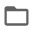

In [ ]:
samples_after = []
for sample_before in samples_before:
    sample_after = filter(sample_before)
    samples_after.append(sample_after)

with open("samples_after.json", "w") as file_obj:
    json.dump(samples_after, file_obj, indent=2)